In [1]:
import pandas as pd
import numpy as np
import json
import os
import operator
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import utils

from pathlib import Path

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(24, 14)}, font_scale=2)

# Functions

In [2]:
def update_df(df, scores_path):
    '''
    Given a wikipages queries dataframe `df` and its respective NDCG `scores_path`
    update df to map the NDCG scores @k for each wikipage
    '''
    for file in os.listdir(scores_path):
        with open(scores_path + file, 'r') as f:
            scores_dict = json.load(f)

        wikipage_id_to_score = {}
        for wikipage_id in scores_dict:
            wikipage_id_to_score[int(wikipage_id)] = scores_dict[wikipage_id]['ndcg']
        
        k = file.split('_')[-1].split('.')[0]
        df['ndcg@'+k] = np.nan
        df['ndcg@'+k] = df['wikipage_id'].map(wikipage_id_to_score)

    return df

def get_query_df_dict(query_df_base_dir, score_paths_base_dir, min_tuple_width, mode, tuples_per_query_list):
    # Dictionary keyed by the number of tuples per query to the query dataframe that contains the NDCG scores at various k values
    query_df_dict = {}

    for tuples_per_query in tuples_per_query_list:
        df = pd.read_pickle(query_df_base_dir+'minTupleWidth_2_tuplesPerQuery_'+str(tuples_per_query)+'.pickle')  
        scores_path = score_paths_base_dir + 'minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_' + str(tuples_per_query) + '/' + mode + '/'

        query_df_dict[tuples_per_query] = update_df(df, scores_path)
    
    return query_df_dict

def get_ndcg_scores_at_k_stats(df_dict, top_k_vals, tuples_per_query_list):
    '''
    Returns the dictionaries indexed by the tuples_per_query corresponding to the mean and standard deviation of the ndcg@k scores
    '''
    mean_ndcg_scores_at_k = {}
    std_ndcg_scores_at_k = {}
    for tuples_per_query in tuples_per_query_list:
        mean_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].mean() for k in top_k_vals]
        std_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].std() for k in top_k_vals]
    return mean_ndcg_scores_at_k, std_ndcg_scores_at_k

In [65]:
def get_relevant_wikipages(wikipage_id, relevance_scores_dir):
    with open(relevance_scores_dir + str(wikipage_id) + '.json') as fp:
        relevant_wikipages = json.load(fp)
    print(relevant_wikipages)

def get_wikipage_attributes(wikipage_id, wikipage_to_attributes_dict, df):
    # Convert the wikipage_id into a wikipage name
    wikipage = df[df['wikipage_id'] == wikipage_id]['wikipage'].values[0]
    wikipage = wikipage.split('/')[-1]
    print(wikipage_to_attributes_dict[wikipage])

def get_query(wikipage_id, queries_path, k=None):
    with open(queries_path + 'wikipage_' + str(wikipage_id) + '.json') as fp:
        query_dict = json.load(fp)
    for tuple in query_dict['queries']:
        print(tuple)

def get_top_k_results(wikipage_id, scores_dir, k=10):
    with open(scores_dir + 'wikipage_' + str(wikipage_id)+'/search_output/filenameToScore.json') as fp:
        scores_dicts = json.load(fp)['scores']
    top_k_wikipages = []
    for dict in scores_dicts[:k]:
        top_k_wikipages.append(dict['pgTitle'])
    return top_k_wikipages

def get_top_k_bm25(wikipage_id, bm_25_scores_dir, table_to_wikipage_id_dict, df, k=10):
    scores_df = pd.read_csv(bm_25_scores_dir, sep="\t", index_col=False, names=["wikipage_id", "query", "table_id", "rank", "score", "field"])
    scores_df = scores_df[scores_df['wikipage_id'] == wikipage_id].sort_values(by='rank')
    top_k_wikipages = []
    for idx, row in scores_df.head(k).iterrows():
        table = row['table_id']
        wikipage_id = table_to_wikipage_id_dict

    

def get_query_summary(wikipage_id, df, relevance_scores_dir, queries_path, wikipage_to_attributes_dict, scores_dir, bm_25_scores_dir, table_to_wikipage_id_dict, k=10):
    print("Query Constructed from Wikipedia Page:", df[df['wikipage_id'] == wikipage_id]['wikipage'].values[0])

    print("\nQuery Tuples:")
    get_query(wikipage_id, queries_path)

    print('\nWikipedia Categories of query Wikipage:')
    get_wikipage_attributes(wikipage_id, wikipage_to_attributes_dict, df)

    print('\nRelevant Wikipages (Ground Truth):')
    get_relevant_wikipages(wikipage_id, relevance_scores_dir)

    print("\nTop-" + str(k), "tables found using Jaccard of DBpedia Types:")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'adjusted_jaccard/', k=k))

    print("\nTop-" + str(k), "tables found using Embeddings (Absolute Cosine):")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'embeddings/abs_cos/', k=k))

    print("\nTop-" + str(k), "tables found using BM25 (Entity Queries):")
    # print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'embeddings/abs_cos/', k=k))

# Search Mode: Brute Force

In [9]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/filtered_queries/'
min_tuple_width=2
tuples_per_query_list = [1, 2, 5, 10]
top_k_vals = [5,10,15,20,50,100,150,200]

## Adjusted Jaccard of DBpedia Types

In [10]:
adj_jaccard_score_paths_base_dir = 'eval_over_search_output/wikipages_expanded/filtered_queries/adjusted_jaccard/'

# Updated Dataframes for Wikipages with Categories (Adjusted Jaccard)
query_df_adjusted_jaccard_categories = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

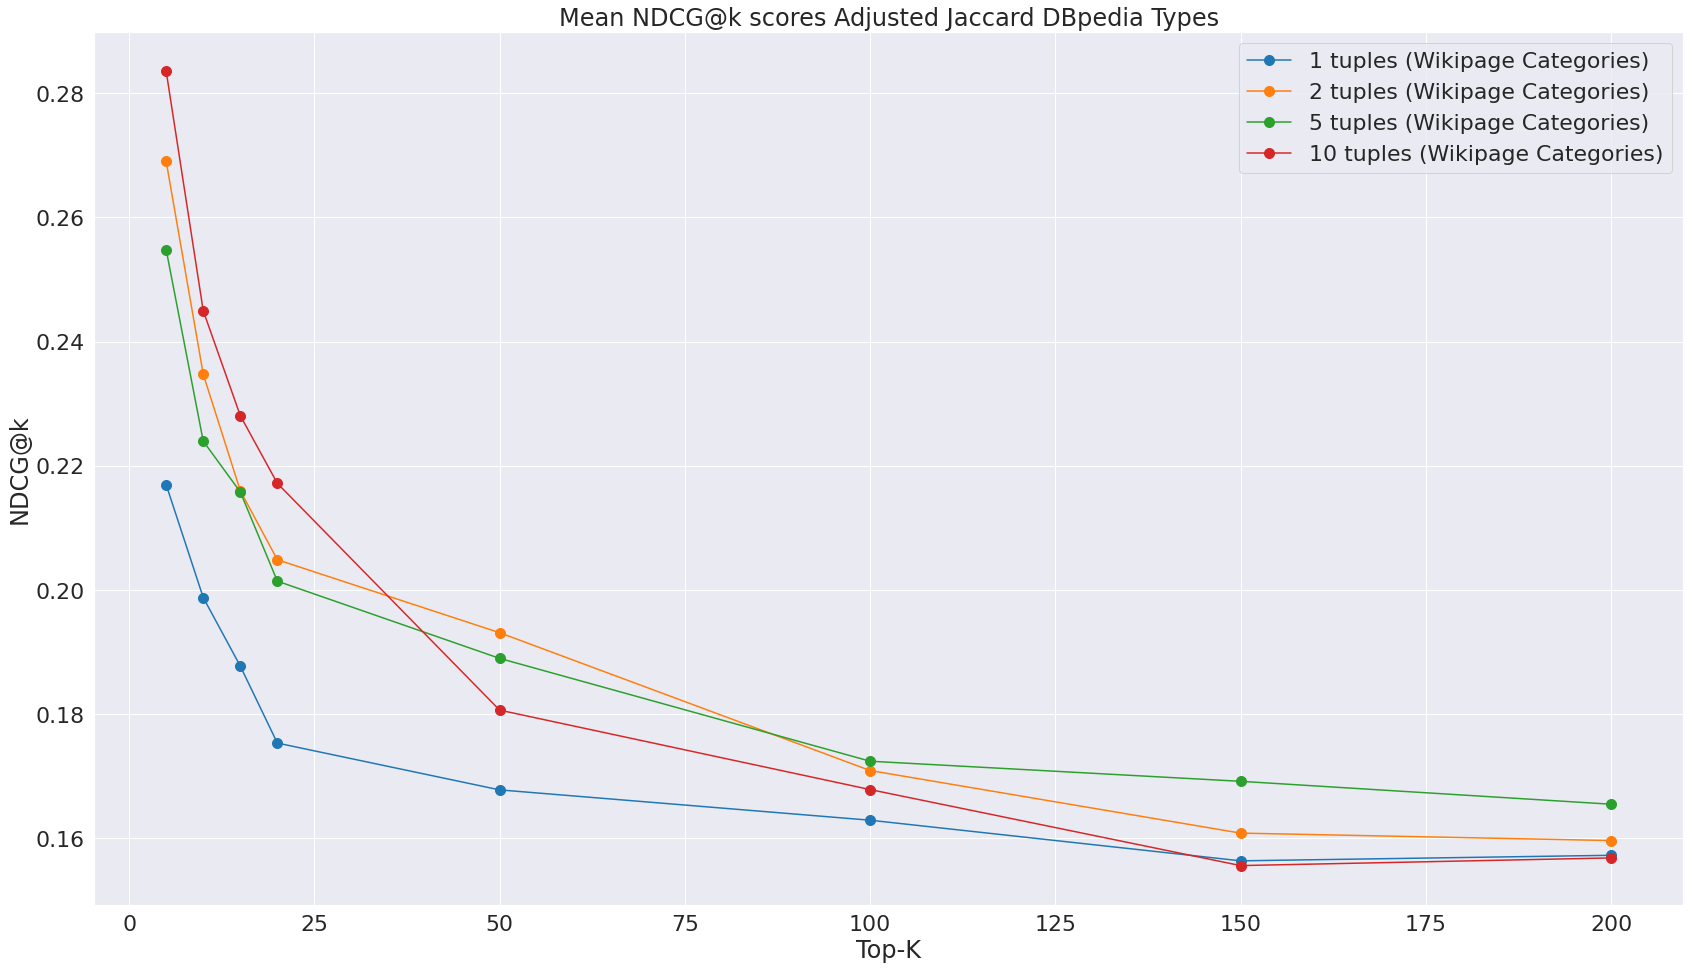

In [14]:
# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
mean_ndcg_scores_at_k_adjusted_jaccard_categories, _ = get_ndcg_scores_at_k_stats(query_df_adjusted_jaccard_categories, top_k_vals, tuples_per_query_list)

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_categories[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Wikipage Categories)')

plt.legend()
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Adjusted Jaccard DBpedia Types');plt.tight_layout()
# plt.savefig('figures/filtered_queries/topk_ndcg@k_adjusted_jaccard_types_categories_vs_navigation_links.svg')

## Embeddings

# Search Mode: BM25 

In [23]:
with open('evaluation_dataframes/wikipages_expanded_filtered_queries_bm25_dfs_dict.pickle', 'rb') as handle:
    dfs_dict = pickle.load(handle)

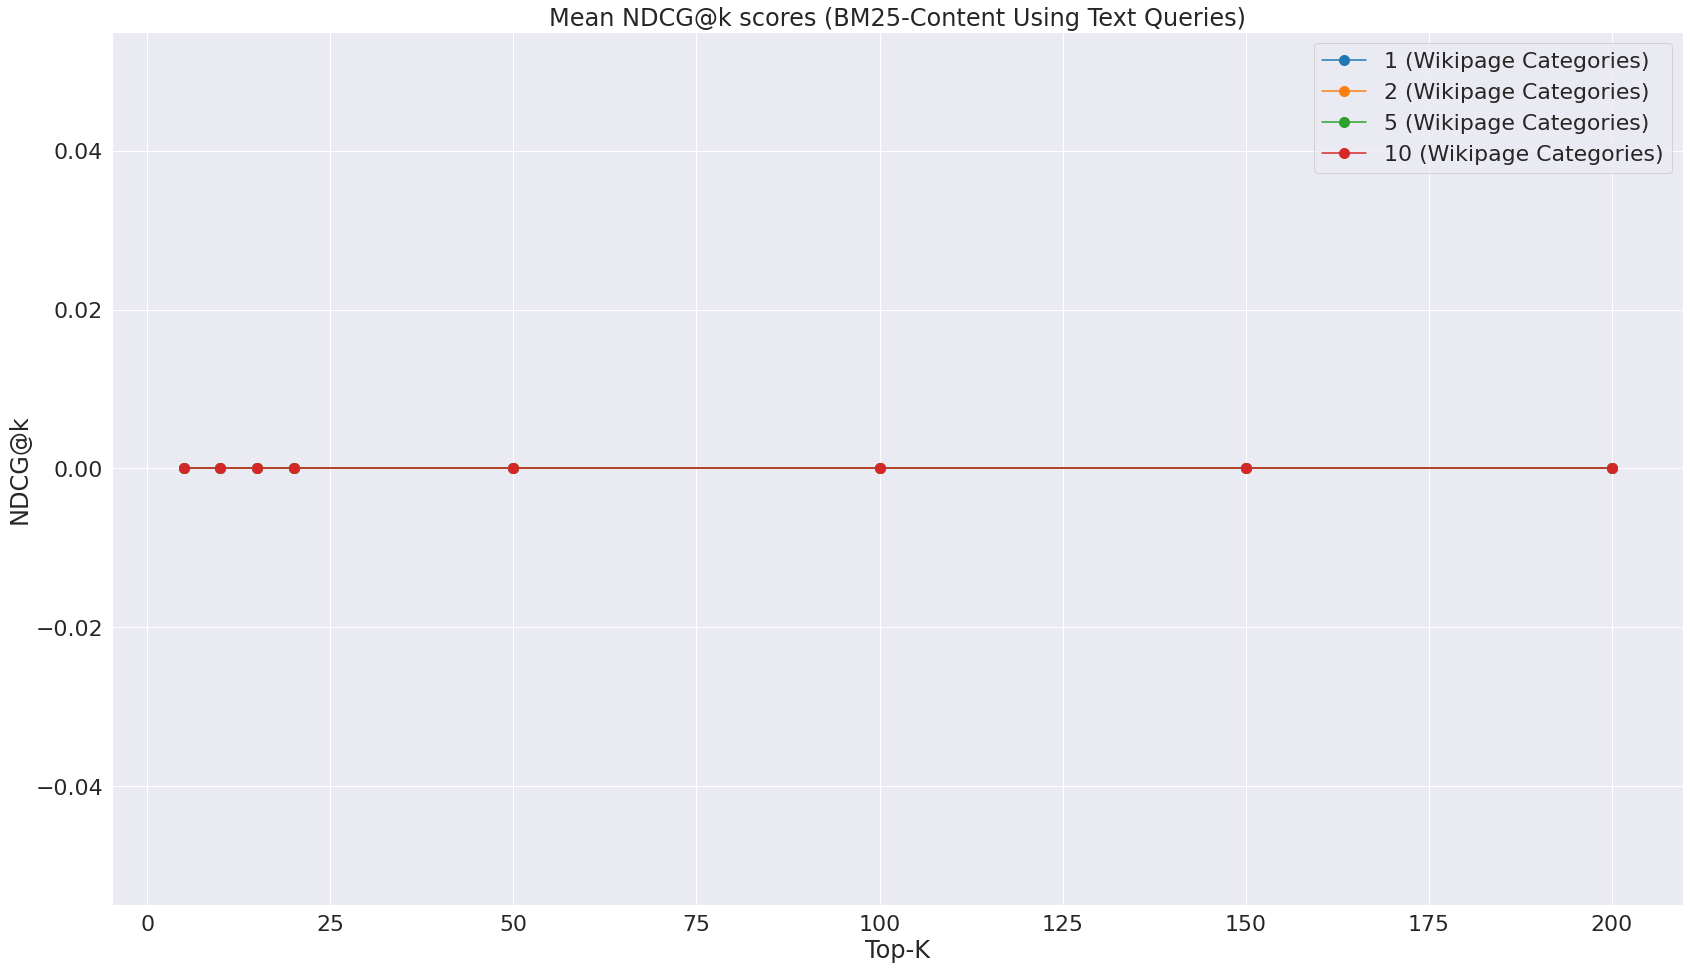

In [25]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['text']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Text Queries)');plt.tight_layout()
# plt.savefig('figures/filtered_queries/expanded_wikipages_dataset_topk_ndcg@k_bm25_text_queries_categories_vs_navigation_links.svg')

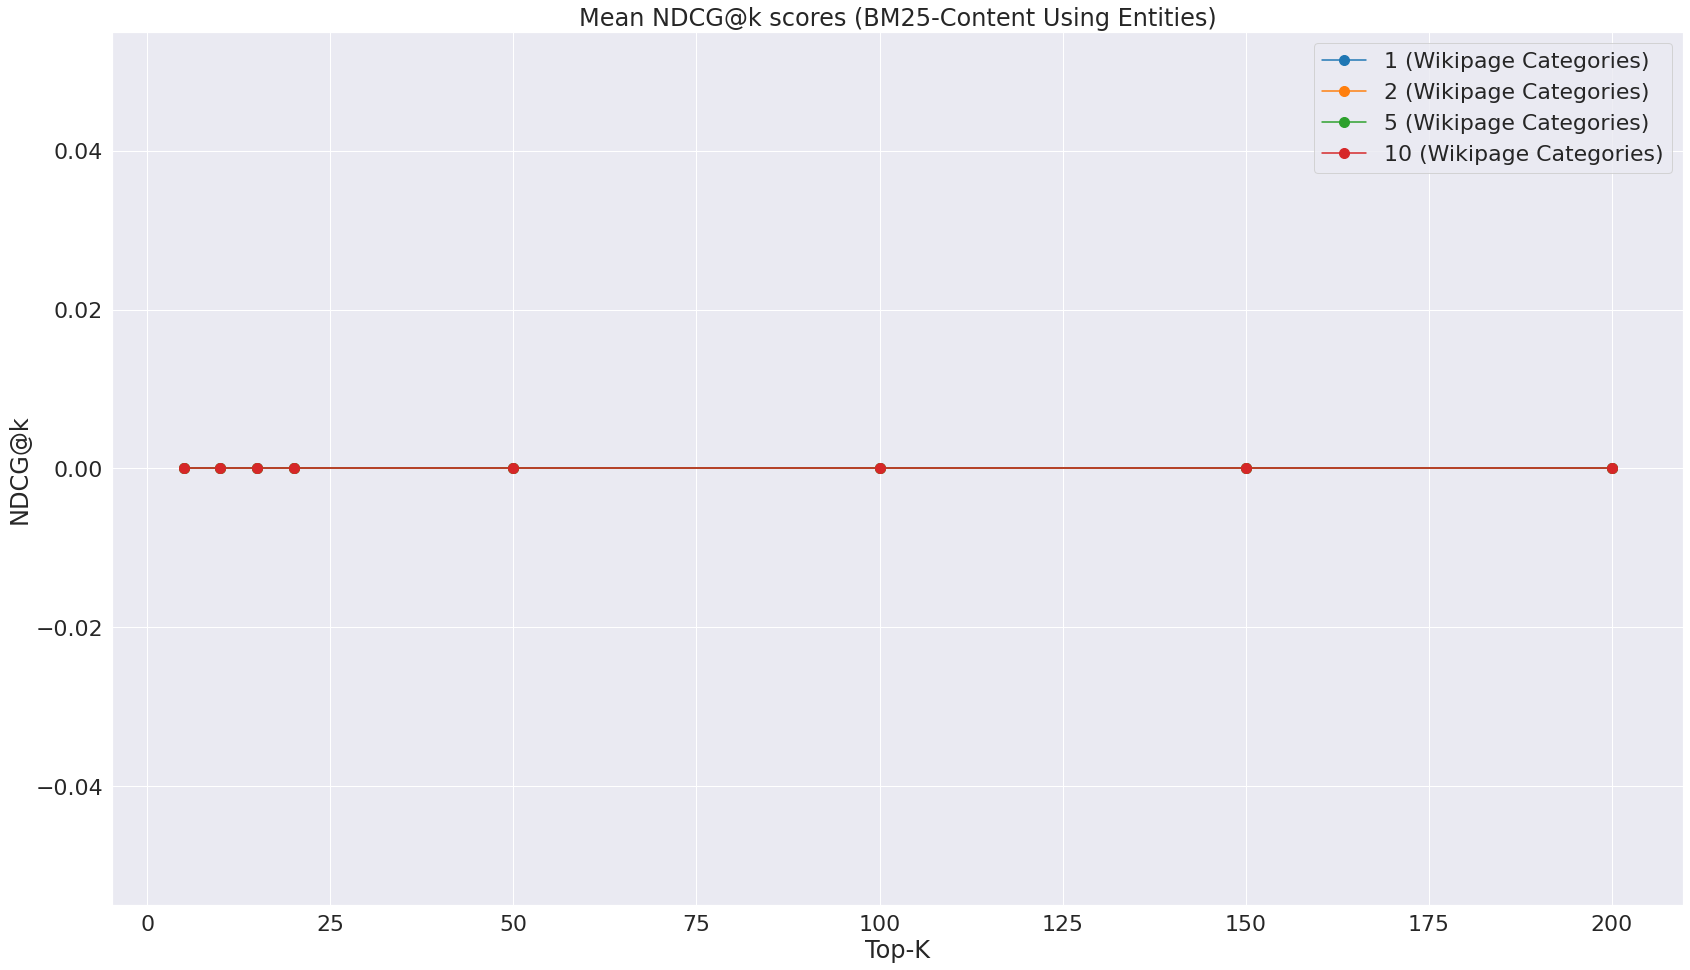

In [ ]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['entities']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Entities)');plt.tight_layout()

# Exploration of output for each Query

In [66]:
get_top_k_bm25(
    wikipage_id=32,
    bm_25_scores_dir='../../Web-Table-Retrieval-Benchmark/data/wikipages_expanded/ranking/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/entities/content.txt',
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, df=df,
    k=10
)

,wikipage_id,query,table_id,rank,score,field
5000,32,Q0,table-0001-242.json,1,66.120140,content
5001,32,Q0,table-0285-274.json,2,61.684456,content
5002,32,Q0,table-0679-733.json,3,38.314140,content
5003,32,Q0,table-0285-281.json,4,36.269806,content
5004,32,Q0,table-0684-547.json,5,33.631615,content
...,...,...,...,...,...,...
5995,32,Q0,table-0566-525.json,996,15.947547,content
5996,32,Q0,table-1564-584.json,997,15.938110,content
5997,32,Q0,table-0493-814.json,998,15.937312,content
5998,32,Q0,table-0723-922.json,999,15.935717,content


In [36]:
queries_df = pd.read_pickle('../../data/queries/wikipages/query_dataframes/expanded_wikipages/filtered_queries/filtered_queries.pickle')
queries_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,categories_relevant_wikipages,categories_relevant_tables,navigation_links_relevant_wikipages,navigation_links_relevant_tables,categories_expansion_ratio,navigation_links_expansion_ratio,avg_query_containment
32,https://en.wikipedia.org/wiki/Andre_Norton_Award,32,1,[table-0001-242.json],[80],4.0,11.0,table-0001-242.json,"[4, 6, 7, 10, 13, 14, 28, 30, 31, 33, 36]",51.0,58.0,NaN,NaN,58.0,NaN,0.036120
1119,https://en.wikipedia.org/wiki/List_of_Norwegia...,1119,1,[table-0007-748.json],[40],3.0,12.0,table-0007-748.json,"[0, 2, 3, 4, 6, 8, 10, 12, 13, 14, 16, 17]",55.0,100.0,NaN,NaN,100.0,NaN,0.024691
1523,https://en.wikipedia.org/wiki/Un_Certain_Regard,1523,1,[table-0010-283.json],[103],4.0,19.0,table-0010-283.json,"[3, 4, 5, 6, 8, 11, 12, 13, 14, 16, 21, 23, 24...",96.0,186.0,NaN,NaN,186.0,NaN,0.013601
7003,https://en.wikipedia.org/wiki/List_of_United_S...,7003,1,[table-0047-348.json],[243],4.0,27.0,table-0047-348.json,"[4, 6, 9, 16, 19, 20, 25, 33, 37, 38, 42, 62, ...",57.0,124.0,NaN,NaN,124.0,NaN,0.010958
20072,https://en.wikipedia.org/wiki/List_of_demolish...,20072,1,[table-0142-322.json],[54],3.0,10.0,table-0142-322.json,"[2, 4, 7, 8, 10, 18, 20, 21, 23, 25]",59.0,142.0,NaN,NaN,142.0,NaN,0.009878
23272,https://en.wikipedia.org/wiki/List_of_football...,23272,1,[table-0166-87.json],[177],4.0,23.0,table-0166-87.json,"[0, 4, 12, 13, 16, 17, 24, 25, 28, 30, 35, 41,...",87.0,104.0,NaN,NaN,104.0,NaN,0.009335
40352,https://en.wikipedia.org/wiki/List_of_Dreamcas...,40352,2,"[table-0283-433.json, table-0283-434.json]","[470, 22]",4.0,156.0,table-0283-433.json,"[0, 1, 2, 4, 18, 19, 26, 27, 51, 56, 60, 62, 6...",84.0,227.0,NaN,NaN,113.5,NaN,0.029280
52690,https://en.wikipedia.org/wiki/List_of_Prime_Mi...,52690,1,[table-0365-306.json],[55],3.0,22.0,table-0365-306.json,"[14, 15, 19, 33, 34, 36, 37, 51, 52, 59, 60, 6...",91.0,113.0,NaN,NaN,113.0,NaN,0.006975
56122,https://en.wikipedia.org/wiki/Highest_mountain...,56122,1,[table-0388-485.json],[56],3.0,22.0,table-0388-485.json,"[3, 5, 6, 12, 13, 16, 17, 19, 27, 28, 32, 34, ...",68.0,111.0,NaN,NaN,111.0,NaN,0.009773
156636,https://en.wikipedia.org/wiki/List_of_prefectu...,156636,1,[table-1068-761.json],[348],3.0,306.0,table-1068-761.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15,...",81.0,150.0,NaN,NaN,150.0,NaN,0.017717


## 2 Tuples Per Query

In [62]:
df = pd.read_pickle('../../data/tables/wikipages/wikipages_expanded_dataset/wikipages_df.pickle')

# Construct a dictionary that maps each table name to its respective wikipage_id
table_to_wikipage_id_dict = {}
for _, row in tqdm(df.iterrows(), total=len(df.index)):
    for table in row['tables']:
        table_to_wikipage_id_dict[table] = row['wikipage_id']

relevance_scores_dir = '../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/jaccard_categories_new/'
wikipage_to_categories_path = '../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/wikipage_to_categories.json'
with open(wikipage_to_categories_path) as fp:
    wikipage_to_categories_dict = json.load(fp)


queries_path='../../data/queries/wikipages/queries/expanded_wikipages/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/'
scores_dir = '../../data/search/expanded_wikipages/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/'
bm_25_scores_dir = '../../Web-Table-Retrieval-Benchmark/data/wikipages_expanded/ranking/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/'

100%|██████████| 149526/149526 [00:05<00:00, 29860.27it/s]


In [59]:
get_query_summary(
    wikipage_id=32, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/Andre_Norton_Award

Query Tuples:
['http://dbpedia.org/resource/2006_in_literature', 'http://dbpedia.org/resource/Justine_Larbalestier', 'http://dbpedia.org/resource/Magic_or_Madness', 'http://dbpedia.org/resource/Penguin_Group']
['http://dbpedia.org/resource/2006_in_literature', 'http://dbpedia.org/resource/Megan_Whalen_Turner', 'http://dbpedia.org/resource/The_King_of_Attolia', 'http://dbpedia.org/resource/HarperCollins']

Wikipedia Categories of query Wikipage:
['2005 Establishments In The United States', "American Children'S Literary Awards", 'American Speculative Fiction Awards', 'Awards Established In 2005', 'Fantasy Awards', 'Science Fiction Awards']

Relevant Wikipages (Ground Truth):
{'Andre_Norton_Award': 1.0, 'List_of_James_Tiptree,_Jr._Award_winners': 0.3, 'Dwarf_Stars_Award': 0.2857142857142857, 'John_W._Campbell_Award_for_Best_New_Writer': 0.2727272727272727, 'Hugo_Award': 0.2222222222222222, 'NWA_Hall_o